# 卷积层的实现


在本课程中，我们将实现一维卷积层。在卷积层的课程中，我们仅讨论了二维卷积，因为它是最常用的。但为了更好地理解代码和卷积层的巧妙设计，从一维卷积开始学习至关重要。


## 一维卷积：原理是什么？


一维卷积与二维卷积非常相似，但仅作用于单个维度。通过实现一维卷积层，我们可以快速理解为什么卷积层本质上是一个 `for` 循环。

![conv1d](./images/conv1d.png)

图片来源：[论坛](https://ai.stackexchange.com/questions/28767/what-does-channel-mean-in-the-case-of-an-1d-convolution)

二维卷积中的经典参数同样适用于一维卷积：
- **填充（padding）**：在一维向量的两端（开头和结尾）添加值
- **步长（stride）**：定义滑动窗口的步幅
- **核大小（kernel_size）**：定义滤波器的尺寸
- **输入通道（in_channels）和输出通道（out_channels）**：分别表示输入和输出的通道数量
- 等等


## 实现


现在我们将实现一维卷积层。

**注意**：在 PyTorch 中，卷积层并非用 Python 实现，而是用 C++ 实现，以提高计算速度。


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

在卷积层中，我们有一个大小为 `kernel_size` 的滤波器维度，以及 `out_channels` 个滤波器。核心思想是遍历整个输入向量，通过将每个滤波器应用于输入向量的每个可能位置，计算输出值。在每个位置上，我们应用一个全连接层，其输入是大小为 $(KernelSize \times InChannels)$ 的滤波器内的元素，并输出 $OutChannels$ 个元素。这类似于在输入序列的每个位置上应用一个 `for` 循环。

**注意**：在示意图中，仅展示了一个通道维度，但实际上大多数情况下有多个通道。


In [14]:
in_channels = 3
out_channels = 16
kernel_size = 3
kernel=nn.Linear(in_channels*kernel_size, out_channels)

接下来，我们需要以 `stride` 指定的步长，将该卷积层应用于序列中的所有元素。如果希望输入序列和输出序列的大小相同，还可以添加 `padding`。


In [21]:
# Imaginons une séquence de 100 éléments, avec 3 canaux et un batch de 8
dummy_input = torch.randn(8, in_channels, 100)
print("Dimension de l'entrée: ",dummy_input.shape)
stride=1
padding=1
outs=[]

# On pad les deux côtés de l'entrée pour éviter les problèmes de dimensions
dummy_input=F.pad(dummy_input, (padding, padding))

for i in range(kernel_size,dummy_input.shape[2]+1,stride):
  chunk=dummy_input[:,:,i-kernel_size:i]
  # On redimensionne pour la couche fully connected
  chunk=chunk.reshape(dummy_input.shape[0],-1)
  # On applique la couche fully connected
  out=kernel(chunk)
  # On ajoute à la liste des sorties
  outs.append(out)
# On convertit la liste en un tenseur
outs=torch.stack(outs, dim=2)
print("Dimension de la sortie: ",outs.shape)

Dimension de l'entrée:  torch.Size([8, 3, 100])
Dimension de la sortie:  torch.Size([8, 16, 100])


与二维卷积类似，我们可以选择减小序列（或二维卷积中的特征图）的大小。为此，可以使用大于 1 的 `stride`，或使用 `pooling` 层。

在实践中，通常更倾向于使用 `stride`，但为了更好地理解其工作原理，我们将实现 `max pooling`。


In [27]:
pooling=2
outs2=[]
for i in range(pooling,outs.shape[2]+1,pooling):
  # On prend les éléments entre i-pooling et i
  chunk=outs[:,:,i-pooling:i]
  # On prend le max sur la dimension 2, pour le average pooling on aurait utilisé torch.mean
  out2=torch.max(chunk, dim=2)[0]
  outs2.append(out2)
# On convertit la liste en un tenseur 
outs2=torch.stack(outs2, dim=2)
print("Dimension de la sortie après pooling: ",outs2.shape)

Dimension de la sortie après pooling:  torch.Size([8, 16, 50])


现在我们已经理解了一维卷积和 `max pooling` 的工作原理，接下来我们将创建类以便更方便地使用它们。


In [29]:
class Conv1D(nn.Module):
  def __init__(self, in_channels, out_channels, stride, kernel_size, padding):
    super(Conv1D, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride
    self.kernel_width = kernel_size
    self.kernel = nn.Linear(kernel_size * in_channels, out_channels)
    self.padding=padding

  def forward(self, x):
    x=F.pad(x, (self.padding, self.padding))
    # Boucle en une seule ligne pour un code plus concis
    l = [self.kernel(x[:, :, i - self.kernel_width: i].reshape(x.shape[0], self.in_channels * self.kernel_width)) for i in range(self.kernel_width, x.shape[2]+1, self.stride)]
    return torch.stack(l, dim=2)


class MaxPool1D(nn.Module):
  def __init__(self, pooling):
    super(MaxPool1D, self).__init__()
    self.pooling = pooling
    
  def forward(self, x):
    # Boucle en une seule ligne pour un code plus concis
    l = [torch.max(x[:, :, i - self.pooling: i], dim=2)[0] for i in range(self.pooling, x.shape[2]+1, self.pooling)]
    return torch.stack(l, dim=2)

## 实践案例：MNIST


现在我们已经实现了卷积层和 `pooling` 层，接下来我们将在 MNIST 数据集上进行测试。在 MNIST 中，我们处理的是图像，因此在实践中使用二维卷积更为合理（详见下一课）。在这里，我们仅验证我们的卷积实现是否正常工作。


In [38]:
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### 数据集


In [39]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

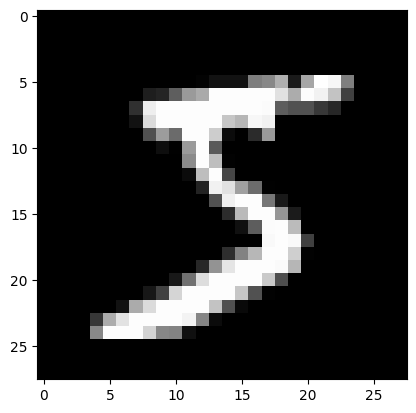

Le chiffre sur l'image est un 0


In [40]:
plt.imshow(dataset[0][0].permute(1,2,0).numpy(), cmap='gray')
plt.show()
print("Le chiffre sur l'image est un "+str(dataset[1][1]))

In [41]:
train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

现在我们可以创建模型了。注意，我们使用 `stride=2` 且不使用 `max pooling`，以减少处理时间。


In [49]:
class cnn1d(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.conv1=Conv1D(1,8,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 8 filtres
    self.conv2=Conv1D(8,16,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 16 filtres
    self.conv3=Conv1D(16,32,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 32 filtres
    self.fc=nn.Linear(3136,10)
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=x.view(-1,x.shape[1]*x.shape[2]) # Pour convertir la feature map de taille CxL en vecteur 1D (avec une dimension batch)
    output=self.fc(x)
    return output
dummy_input=torch.randn(8,1,784)
model=cnn1d()
output=model(dummy_input)
print(output.shape)

print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

torch.Size([8, 10])
Nombre de paramètres 33370


该模型的参数量几乎比之前课程中的全连接模型少 10 倍！


In [50]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [51]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    images=images.view(images.shape[0],1,784)
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      images=images.view(images.shape[0],1,784)
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.4011246860027313
step 0 val loss 0.2103319615125656
step 1 train loss 0.17427290976047516
step 1 val loss 0.1769915670156479
step 2 train loss 0.14464063942432404
step 2 val loss 0.14992524683475494
step 3 train loss 0.12802869081497192
step 3 val loss 0.13225941359996796
step 4 train loss 0.11609579622745514
step 4 val loss 0.12663421034812927


In [53]:
correct = 0
total = 0
for images,labels in test_loader:
  images=images.view(images.shape[0],1,784) 
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  96.35


我们获得了非常好的精度，尽管略低于之前课程中全连接网络的精度。

**注意**：训练速度较慢，因为我们的实现效率不高。PyTorch 中用 C++ 实现的卷积层性能要好得多。

**注意 2**：我们使用了一维卷积来处理图像，这并非最优选择。最佳做法是使用二维卷积。


## 扩展：二维卷积


我们可以按照相同的原理实现二维卷积，但需要在两个维度上进行操作。


In [15]:
in_channels = 3
out_channels = 16
kernel_size = 3
# On a un kernel de taille 3x3 car on est en 2D
kernel=nn.Linear(in_channels*kernel_size**2, out_channels)

In [16]:
# Pour une image de taille 10x10 avec 3 canaux et un batch de 8
dummy_input = torch.randn(8, in_channels, 10,10)
b, c, h, w = dummy_input.shape
print("Dimension de l'entrée: ",dummy_input.shape)
stride=1
padding=1
outs=[]

# Le padding change pour une image 2D, on doit pad en hauteur et en largeur
dummy_input=F.pad(dummy_input, (padding, padding,padding,padding))
print("Dimension de l'entrée après padding: ",dummy_input.shape)

# On boucle sur les dimensions de l'image : W x H 
for i in range(kernel_size,dummy_input.shape[2]+1,stride):
  for j in range(kernel_size,dummy_input.shape[3]+1,stride):
    chunk=dummy_input[:,:,i-kernel_size:i,j-kernel_size:j]
    # On redimensionne pour la couche fully connected
    chunk=chunk.reshape(dummy_input.shape[0],-1)
    # On applique la couche fully connected
    out=kernel(chunk)
    # On ajoute à la liste des sorties
    outs.append(out)
# On convertit la liste en un tenseur
outs=torch.stack(outs, dim=2)
outs=outs.reshape(b,out_channels,h, w)
print("Dimension de la sortie: ",outs.shape)

Dimension de l'entrée:  torch.Size([8, 3, 10, 10])
Dimension de l'entrée après padding:  torch.Size([8, 3, 12, 12])
Dimension de la sortie:  torch.Size([8, 16, 10, 10])


现在我们可以像实现一维卷积那样，在课堂上实现它。


In [34]:
class Conv2D(nn.Module):
  def __init__(self, in_channels, out_channels, stride, kernel_size, padding):
    super(Conv2D, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride
    self.kernel_width = kernel_size
    self.kernel = nn.Linear(in_channels*kernel_size**2 , out_channels)
    self.padding=padding

  def forward(self, x):
    b, c, h, w = x.shape
    x=F.pad(x, (self.padding, self.padding,self.padding,self.padding))
    # Sur une seule ligne, c'est absolument illisible, on garde la boucle
    l=[]
    for i in range(self.kernel_width, x.shape[2]+1, self.stride):
      for j in range(self.kernel_width, x.shape[3]+1, self.stride):
        chunk=self.kernel(x[:,:,i-self.kernel_width:i,j-self.kernel_width:j].reshape(x.shape[0],-1))
        l.append(chunk)
    # La version en une ligne, pour les curieux
    #l = [self.kernel(x[:, :, i - self.kernel_width: i, j - self.kernel_width: j].reshape(x.shape[0], ,-1)) for i in range(self.kernel_width, x.shape[2]+1, self.stride) for j in range(self.kernel_width, x.shape[3]+1, self.stride)]
    outs=torch.stack(l, dim=2)
    return outs.reshape(b,self.out_channels,h//self.stride, w//self.stride)

dummy_input=torch.randn(8,3,32,32)
model=Conv2D(3,16,stride=2,kernel_size=3,padding=1)
output=model(dummy_input)
print(output.shape)

torch.Size([8, 16, 16, 16])


现在我们可以创建模型了。


In [50]:
class cnn2d(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.conv1=Conv2D(1,8,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 8 filtres
    self.conv2=Conv2D(8,16,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 16 filtres
    self.conv3=Conv2D(16,32,kernel_size=3,stride=1,padding=1) # Couche de convolution 1D de 32 filtres
    self.fc=nn.Linear(1568,10)
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=x.view(-1,x.shape[1]*x.shape[2]*x.shape[3]) # Pour convertir la feature map de taille CxL en vecteur 1D (avec une dimension batch)
    output=self.fc(x)
    return output
dummy_input=torch.randn(8,1,28,28)
model=cnn2d()
output=model(dummy_input)
print(output.shape)

print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

torch.Size([8, 10])
Nombre de paramètres 21578


现在我们可以在 MNIST 上训练模型，并查看其是否比一维卷积的结果更好。


In [51]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [52]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.36240848898887634
step 0 val loss 0.14743468165397644
step 1 train loss 0.1063414067029953
step 1 val loss 0.1019362062215805
step 2 train loss 0.07034476101398468
step 2 val loss 0.08669546991586685
step 3 train loss 0.05517915263772011
step 3 val loss 0.07208992540836334
step 4 train loss 0.04452721029520035
step 4 val loss 0.0664198026061058


在损失函数（`loss`）方面，我们的模型比使用一维卷积时取得了更低的值。


In [53]:
correct = 0
total = 0
for images,labels in test_loader:
  with torch.no_grad():
    preds=model(images)
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  98.23


精度非常高！尽管参数量减少了 10 倍，但它仍然比我们之前使用的[全连接网络](../02_RéseauFullyConnected/03_TechniquesAvancées.ipynb)效果更好。


**注意**：同样地，我们可以实现三维卷积，用于视频处理（增加时间轴）。